# Load LGMR sat data
Ref: Osman et al., 2021

In [43]:
import xarray as xr
import numpy as np

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs_MC = xr.open_dataset(data_dir + '/ds_sat_EOFs_MC.nc')

weight = np.cos(np.deg2rad(ds_sat_EOFs_MC['lat']))
weight = xr.where(weight < 0, 0, weight)

ds_sat_EOFs_MC['weight']=weight

# ds_sat_EOFs_MC.info

# Get the T at 60°S

11.677394449710846

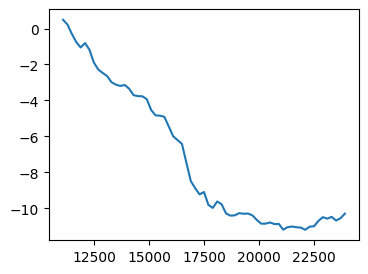

In [24]:
import xarray as xr

selected_data_at_60s = ds_sat_EOFs_MC.sel(lat=-60, method="nearest")

LGMR_sat_60s = selected_data_at_60s['sat'].mean(dim='lon')

import matplotlib.pyplot as plt

# Plotting the mean SAT time series at latitude -60 degrees
plt.figure(figsize=(4, 3))  # Set the figure size
plt.plot(LGMR_sat_60s['age'], LGMR_sat_60s, label='Mean SAT at -60°')

sat_at_21000 = LGMR_sat_60s.sel(age=21000, method='nearest').item()
sat_at_11000 = LGMR_sat_60s.sel(age=11000, method='nearest').item()

# Calculate the difference: later (11000) - former (21000)
difference = sat_at_11000 - sat_at_21000
difference


# Extract the data between 50 to 70°S, and calculate the weighted average

In [44]:
import xarray as xr
from toolbox import change_point_functions as cpf

ds_sat_EOFs_MC = cpf.cal_anomalies(ds_sat_EOFs_MC, years=2000)
ds_sat_subset = ds_sat_EOFs_MC.sel(lat=slice(-70, -50))

weights_broadcasted = ds_sat_subset['weight'].broadcast_like(ds_sat_subset['sat'])
sum_weighted_sat = (ds_sat_subset['sat_anomalies'] * weights_broadcasted).sum(dim=['lat', 'lon'])
sum_weight_sat = weights_broadcasted.sum(dim=['lat', 'lon'])

weighted_avg_sat_mean = sum_weighted_sat / sum_weight_sat

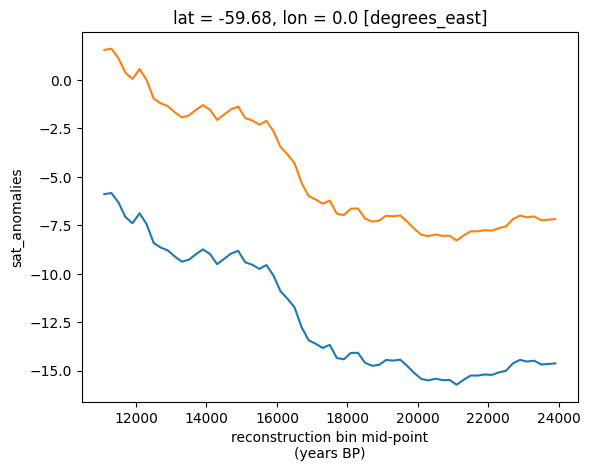

In [48]:
from matplotlib import pyplot as plt

ds_sat_EOFs_MC['sat'].sel(lat=-60, lon=0,method='nearest').plot()
ds_sat_EOFs_MC['sat_anomalies'].sel(lat=-60, lon=0,method='nearest').plot()


# Do the same for the ensamble LGMR data

In [15]:
# read the processed netcdf file
import xarray as xr
import numpy as np
from toolbox import change_point_functions as cpf

ds_sat_processed = xr.open_dataset('ens_ana_data/LGMR_SAT_ens_processed.nc')
ds_sat=ds_sat_processed
weight = np.cos(np.deg2rad(ds_sat['lat']))
# set weight to 0 if it is smaller than 0
weight = xr.where(weight < 0, 0, weight)

ds_sat['weight']=weight

weighted_avg_sat_ens=[]
    
for i in range(len(ds_sat['nEns'])):
    # Select the ensemble member
    ds_sat_i = ds_sat.isel(nEns=i)
    ds_sat_i = cpf.cal_anomalies(ds_sat_i, years=2000)
    ds_sat_subset = ds_sat_i.sel(lat=slice(-70, -50))

    weights_broadcasted = ds_sat_subset['weight'].broadcast_like(ds_sat_subset['sat'])
    sum_weighted_sat = (ds_sat_subset['sat_anomalies'] * weights_broadcasted).sum(dim=['lat', 'lon'])
    sum_weight_sat = weights_broadcasted.sum(dim=['lat', 'lon'])

    weighted_avg_sat = sum_weighted_sat / sum_weight_sat
    weighted_avg_sat_ens.append(weighted_avg_sat.values)
    # if i==10:
    #     break


In [16]:
# preserve the weighted_avg_sat_mean using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/weighted_avg_sat_mean.pickle', 'wb') as f:
    pickle.dump(weighted_avg_sat_mean, f)

# preserve the weighted_avg_sat_ens using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/weighted_avg_sat_ens.pickle', 'wb') as f:
    pickle.dump(weighted_avg_sat_ens, f)

# Read LGMR SIC data
Ref: New data from M. Osman

In [9]:
path='D:/VScode/Last_deglaciation/data/LGMR_SIC_May2023.nc'

# read the nc file from the path
import xarray as xr
import numpy as np

ds_seaice = xr.open_dataset(path)
ds_seaice = ds_seaice.where(ds_seaice.age>=11000, drop=True)

# Calculate the weight based on latitude
weight = np.cos(np.deg2rad(ds_seaice['lat']))
print('shape of the weight:', weight.shape)

weight = xr.where(weight < 0, 0, weight)

ds_seaice['weight'] = weight


ds_seaice

shape of the weight: (96,)


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (dims: 5, age: 65, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 1.11e+04 1.13e+04 1.15e+04 ... 2.37e+04 2.39e+04
  * dims     (dims) object 'mean              ' ... '97.5percentile    '
Data variables:
    sic      (dims, age, lat, lon) float32 0.0 0.0 0.0 ... 0.9979 0.9979 0.9979
    weight   (lat) float32 0.0 0.03306 0.06609 0.09905 ... 0.06609 0.03306 0.0

# Clculate the sea ice area of the LGMR

In [2]:
import xarray as xr


ds_seaice_subset = ds_seaice.sel(lat=slice(-90, 0))


import numpy as np

# Constants
R = 6371  # Earth's radius in km
delta_theta= 2.5/180*np.pi # 2.5 degree in radians

# Convert latitude values to radians
lat_radians = np.radians(ds_seaice_subset['lat'].values)
print('shape of lat_radians:', lat_radians.shape)
# Compute latitudinal boundaries
lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2
print('shape of lat_boundaries:', lat_boundaries.shape)

A=R**2*delta_theta*(np.sin(lat_boundaries[1:])-np.sin(lat_boundaries[:-1]))# area of each grid, Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
print('shape of A:', A.shape)

A_center_lats=ds_seaice_subset['lat'].values[1:-1]
print('shape of A_center_lats:', A_center_lats.shape)

# remove the data corresponds to the last and firs lat in ds_seaice_subset
ds_seaice_subset_reduced=ds_seaice_subset.isel(lat=slice(1,-1))


# Step 1: Create an xarray DataArray for A with the dimension 'lat' and values of 'A_center_lats'
A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

# Step 2: Multiply sic data at dim=0 with A
# Selecting the mean sea ice concentration (sic at dim=0)
sic_mean = ds_seaice_subset_reduced['sic'][0, :, :]

# Multiplying sic with A
sic_area = sic_mean * A_xr

# Step 3: Sum up the resulting product over the latitude (and longitude, if needed)
LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values/1e6

# add age to LGMR_sic_area so it got two columns
LGMR_sic_area=np.column_stack((ds_seaice_subset_reduced['age'].values,LGMR_sic_area))

# save the LGMR_sic_area using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/LGMR_sic_area.pickle', 'wb') as f:
    pickle.dump(LGMR_sic_area, f)

# LGMR_sic_area


shape of lat_radians: (48,)
shape of lat_boundaries: (47,)
shape of A: (46,)
shape of A_center_lats: (46,)


Text(0, 0.5, 'Sea ice area (10^6 km^2)')

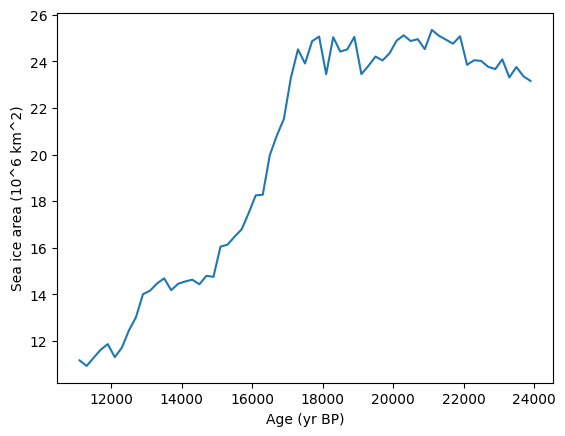

In [5]:
#plot total_sic_area
import matplotlib.pyplot as plt
plt.plot(LGMR_sic_area[:,0],LGMR_sic_area[:,1]) 
plt.xlabel('Age (yr BP)')
plt.ylabel('Sea ice area (10^6 km^2)') 

# Read orbital parameters
Ref: Laskar et al., 2004

In [6]:
# Read the ecc_0_500kyr_inter100.txt under /data_fig3

import pandas as pd

path='D:/VScode/Last_deglaciation/data_fig3/'
df_ecc=pd.read_csv(path+'ecc_0_500kyr_inter100.txt', sep='\s+', header=None)
df_ecc.columns=['age', 'ecc']
df_ecc['age']=-1*df_ecc['age']*1000
df_ecc=df_ecc.iloc[::-1]
df_ecc.to_csv(path+'df_ecc.csv', index=False)

df_ecc

,age,ecc
5000,-0.0,0.016702
4999,100.0,0.016750
4998,200.0,0.016797
4997,300.0,0.016845
4996,400.0,0.016892
...,...,...
4,499600.0,0.033901
3,499700.0,0.033871
2,499800.0,0.033841
1,499900.0,0.033812


In [11]:
import pandas as pd

path='D:/VScode/Last_deglaciation/data_fig3/'
df_obl=pd.read_csv(path+'obliquity_0_500kyr_inter100.txt', sep='\s+', header=None)
df_obl.columns=['age', 'obl']
df_obl['age']=-1*df_obl['age']*1000
df_obl=df_obl.iloc[::-1]
df_obl.to_csv(path+'df_obl.csv', index=False)
df_obl

,age,obl
5000,-0.0,0.409093
4999,100.0,0.409320
4998,200.0,0.409547
4997,300.0,0.409773
4996,400.0,0.410000
...,...,...
4,499600.0,0.414205
3,499700.0,0.414106
2,499800.0,0.414005
1,499900.0,0.413902


In [10]:
# Read the pre_0_500kyr_inter100.txt under /data_fig3

import pandas as pd

path='D:/VScode/Last_deglaciation/data_fig3/'
df_pre=pd.read_csv(path+'pre_0_500kyr_inter100.txt', sep='\s+', header=None)
df_pre.columns=['age', 'pre']
df_pre['age']=-1*df_pre['age']*1000
df_pre=df_pre.iloc[::-1]
df_pre.to_csv(path+'df_pre.csv', index=False)

df_pre

,age,pre
5000,-0.0,0.016280
4999,100.0,0.016431
4998,200.0,0.016568
4997,300.0,0.016690
4996,400.0,0.016798
...,...,...
4,499600.0,0.012835
3,499700.0,0.011893
2,499800.0,0.010943
1,499900.0,0.009986


# Read EBM data

In [3]:
# read the /data_fig3/EMB_results.xlsx
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
df_full_orbital_EBM=pd.read_excel(path+'EBM_results_corrected.xlsx', sheet_name='Full-orbital')
# the first column*1000
df_full_orbital_EBM['age']=df_full_orbital_EBM['age']*1000
# save the df_full_orbital to csv
df_full_orbital_EBM.to_csv(path+'df_full_orbital_EBM.csv', index=False)
df_full_orbital_EBM.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,427.336750,5.564279,-1.029714,23.891422,43,157.8
1,11000,428.465963,5.557092,-1.058631,24.010389,39,158.0
2,12000,430.701655,5.551410,-1.096506,24.172172,31,158.0
3,13000,433.812557,5.542759,-1.128241,24.309235,33,157.6
4,14000,437.481913,5.532736,-1.161961,24.439776,35,156.9


In [5]:
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
df_obl_EBM=pd.read_excel(path+'EBM_results_corrected.xlsx', sheet_name='Obl only')
# the first column*1000
df_obl_EBM['age']=df_obl_EBM['age']*1000
# save the df_obl to csv
df_obl_EBM.to_csv(path+'df_obl_EBM.csv', index=False)

df_obl_EBM.head()


,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,459.746961,5.611897,-0.875833,23.277180,54,151.6
1,11000,459.507869,5.609221,-0.887880,23.318499,52,151.6
2,12000,459.008157,5.601252,-0.900807,23.362572,51,151.5
3,13000,458.269966,5.590614,-0.941276,23.520230,43,151.4
4,14000,457.304724,5.579810,-0.979437,23.664244,54,151.4


In [6]:
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
df_pre_EBM=pd.read_excel(path+'EBM_results_corrected.xlsx', sheet_name='Pre only')
# the first column*1000
df_pre_EBM['age']=df_pre_EBM['age']*1000
# save the df_pre to csv
df_pre_EBM.to_csv(path+'df_pre_EBM.csv', index=False)

df_pre_EBM.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,412.025115,5.331131,-1.742332,26.476820,40,155.8
1,11000,413.305523,5.328999,-1.764071,26.576976,38,156.1
2,12000,415.883287,5.328904,-1.769939,26.615937,37,156.1
3,13000,419.527759,5.333255,-1.765434,26.611126,39,155.9
4,14000,423.936889,5.334003,-1.755265,26.576909,34,155.2


In [7]:
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
df_GHG_EBM=pd.read_excel(path+'EBM_results_corrected.xlsx', sheet_name='GHG')
# the first column*1000
df_GHG_EBM['age']=df_GHG_EBM['age']*1000
# save the df_pre to csv
df_GHG_EBM.to_csv(path+'df_GHG_EBM.csv', index=False)

df_GHG_EBM.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,427.336750,5.564279,2.548542,11.794610,35,157.8
1,11000,428.465963,5.557092,2.655429,11.442139,42,158.0
2,12000,430.701655,5.551410,1.846439,14.263134,34,158.0
3,13000,433.812557,5.542759,1.749034,14.615075,42,157.6
4,14000,437.481913,5.532736,1.649764,14.990463,31,156.9


In [10]:
import pandas as pd
path='D:/VScode/Last_deglaciation/EBM_data/'
df_orb_noice_EBM=pd.read_excel(path+'EBM_results_corrected.xlsx', sheet_name='All Forcing')
# the first column*1000
df_orb_noice_EBM['age']=df_orb_noice_EBM['age']*1000
# save the df_pre to csv
df_orb_noice_EBM.to_csv(path+'df_all_forcing_EBM.csv', index=False)

df_orb_noice_EBM.head()

,age,60S summer inso (21 Dec to 21 Feb),Inter_summer_inso,SAT (50 to 70S),iceA (SH),ice_asy,summer_duration
0,10000,427.336750,5.564279,2.517873,11.903615,39,157.8
1,11000,428.465963,5.557092,2.454374,12.136794,43,158.0
2,12000,430.701655,5.551410,1.476181,15.510074,39,158.0
3,13000,433.812557,5.542759,1.187269,16.530932,32,157.6
4,14000,437.481913,5.532736,0.899832,17.528899,40,156.9


# Load TraCE data
Ref He et al., 2011

In [56]:
import xarray as xr

path='D:/VScode/Last_deglaciation/TraCE_data/'
trace_orb = xr.open_dataset(path + 'b30.00_4kaDVTj.cam2.ncrcat.ann.nc')
trace_allforcing_sat = xr.open_dataset(path+'trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')
trace_allforcing_sic=xr.open_dataset(path+'trace.01-36.22000BP.cam2.ICEFRAC.22000BP_decavg_400BCE.nc')


trace_orb = trace_orb.rename({'TREFHT': 'sat'})
trace_orb = trace_orb.rename({'time': 'age'})
trace_orb['age'] = trace_orb['age'] * -1000
trace_orb['sat'] = trace_orb['sat'] - 273.15 # convert to Celsius

trace_orb_sat = trace_orb[['sat']]
trace_orb_sic = trace_orb[['ICEFRAC']]


trace_allforcing_sat = trace_allforcing_sat.rename({'TREFHT': 'sat'})
trace_allforcing_sat = trace_allforcing_sat.rename({'time': 'age'})
trace_allforcing_sat['age'] = trace_allforcing_sat['age'] * -1000
trace_allforcing_sat['sat'] = trace_allforcing_sat['sat'] - 273.15
trace_allforcing_sat = trace_allforcing_sat[['sat']]


trace_allforcing_sic = trace_allforcing_sic.rename({'time': 'age'})
trace_allforcing_sic['age'] = trace_allforcing_sic['age'] * -1000
trace_allforcing_sic = trace_allforcing_sic[['ICEFRAC']]


6.774467945098877

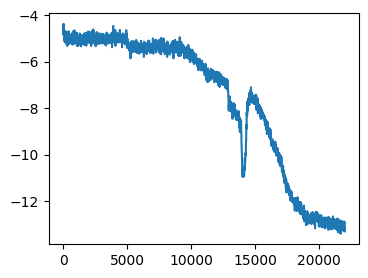

In [27]:
import xarray as xr

selected_data_at_60s = trace_allforcing_sat.sel(lat=-60, method="nearest")

trace_sat_60s = selected_data_at_60s['sat'].mean(dim='lon')

import matplotlib.pyplot as plt

# Plotting the mean SAT time series at latitude -60 degrees
plt.figure(figsize=(4, 3))  # Set the figure size
plt.plot(trace_sat_60s['age'], trace_sat_60s, label='Mean SAT at -60°')

sat_at_21000 = trace_sat_60s.sel(age=21000, method='nearest').item()
sat_at_11000 = trace_sat_60s.sel(age=11000, method='nearest').item()

# Calculate the difference: later (11000) - former (21000)
difference = sat_at_11000 - sat_at_21000
difference

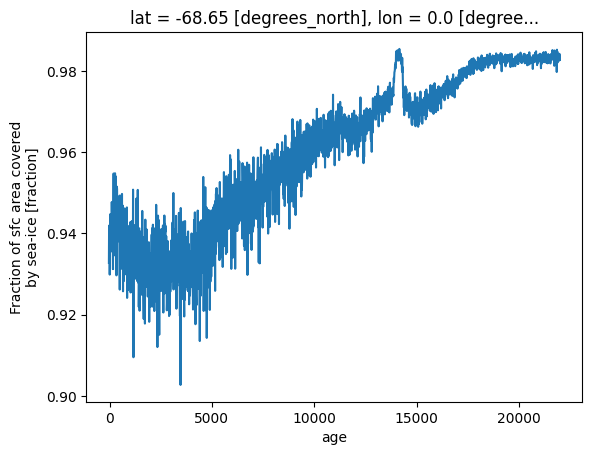

In [7]:
import matplotlib.pyplot as plt

# Selecting the ICEFRAC data variable and then the specific grid cell
icefrac_data = trace_allforcing_sic['ICEFRAC'].isel(lat=5, lon=0)

# Now plot the data
icefrac_data.plot()

plt.show()


# Calculate the weighted average for the given latitude band for TraCE data

In [ ]:
# Function to calculate the weighted average SAT
import numpy as np
import xarray as xr

def calculate_weighted_avg_sat(ds, lat_min=-75, lat_max=-60):
    # Calculate the weight based on latitude
    weight = np.cos(np.deg2rad(ds['lat']))
    weight = xr.where(weight < 0, 0, weight)
    ds['weight'] = weight

    # Select the subset based on latitude
    trace_orb_sat_subset = ds.sel(lat=slice(lat_min, lat_max))

    # Broadcast the weights to the same shape as 'sat'
    weights_broadcasted = trace_orb_sat_subset['weight'].broadcast_like(trace_orb_sat_subset['sat'])

    # Calculate the sum of weighted 'sat' values and the sum of weights
    sum_weighted_sat = (trace_orb_sat_subset['sat'] * weights_broadcasted).sum(dim=['lat', 'lon'])
    sum_weights = weights_broadcasted.sum(dim=['lat', 'lon'])

    # Calculate the weighted average
    weighted_avg_sat = sum_weighted_sat / sum_weights

    return weighted_avg_sat



In [ ]:
weighted_avg_orb = calculate_weighted_avg_sat(trace_orb_sat, lat_min=-70, lat_max=-50)
weighted_avg_allforcing = calculate_weighted_avg_sat(trace_allforcing_sat, lat_min=-70, lat_max=-50)

# Process data and store

In [ ]:

sat_series_orb = weighted_avg_orb.to_series()
sat_series_allforcing = weighted_avg_allforcing.to_series()

# Calculate a 20 point moving average, centered
smoothed_sat_orb = sat_series_orb.rolling(window=20, center=True).mean()
smoothed_sat_allforcing = sat_series_allforcing.rolling(window=20, center=True).mean()

trace_age=trace_orb_sat['age'].values
# convert the sat_series_orb, sat_series_ghg, smoothed_sat_orb, smoothed_sat_ghg to ndarray
sat_series_orb=sat_series_orb.to_numpy()
sat_series_allforcing=sat_series_allforcing.to_numpy()
smoothed_sat_orb=smoothed_sat_orb.to_numpy()
smoothed_sat_allforcing=smoothed_sat_allforcing.to_numpy()


path='D:/VScode/Last_deglaciation/data_fig3/'
# save the array
np.save(path+'trace_age.npy',trace_age)
np.save(path+'sat_series_orb.npy',sat_series_orb)
np.save(path+'sat_series_allforcing.npy',sat_series_allforcing)

np.save(path+'smoothed_sat_orb.npy',smoothed_sat_orb)
np.save(path+'smoothed_sat_allforcing.npy',smoothed_sat_allforcing)


# Calculate sea ice area forTraCE

In [38]:
import xarray as xr
import numpy as np
import pickle

def calculate_seaice_area(ds_seaice, variable_name='sic'):    
    # Subset dataset for latitude from -90 to 0
    ds_seaice_subset = ds_seaice.sel(lat=slice(-90, 0))

    # Constants
    R = 6371  # Earth's radius in km
    delta_theta = 2.5 / 180 * np.pi  # 2.5 degree in radians

    # Convert latitude values to radians and compute latitudinal boundaries
    lat_radians = np.radians(ds_seaice_subset['lat'].values)
    lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2

    # area of each grid, 
    # Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
    A = R**2 * delta_theta * (np.sin(lat_boundaries[1:]) - np.sin(lat_boundaries[:-1]))
    A_center_lats = ds_seaice_subset['lat'].values[1:-1]

    # Reduce dataset size
    ds_seaice_subset_reduced = ds_seaice_subset.isel(lat=slice(1, -1))

    # Create an xarray DataArray for A
    A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

    # Multiply sic data with A
    sic = ds_seaice_subset_reduced[variable_name]
    sic_area = sic * A_xr

    # Sum up the resulting product
    LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values / 1e6
    # print('LGMR_sic_area:', LGMR_sic_area.shape)

    # Add age to LGMR_sic_area
    LGMR_sic_area = np.column_stack((ds_seaice_subset_reduced['age'].values, LGMR_sic_area))

    return LGMR_sic_area


In [36]:

asice_trace_orb=calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC')
asice_trace_allforcing=calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC') 

In [ ]:
# save the asice_trace_orb using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/asice_trace_orb.pickle', 'wb') as f:
    pickle.dump(asice_trace_orb, f)

# save the asice_trace_allforcing using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/asice_trace_allforcing.pickle', 'wb') as f:
    pickle.dump(asice_trace_allforcing, f)

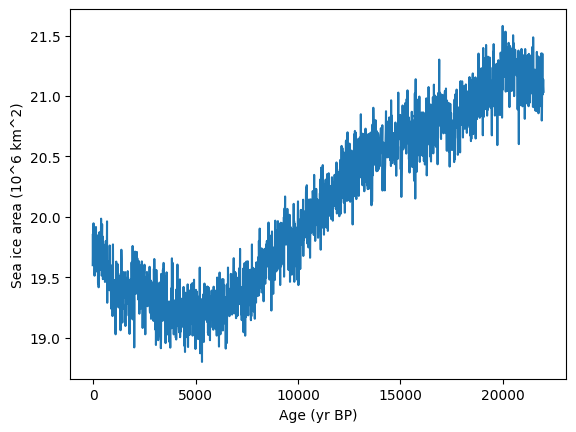

In [39]:
# plot the asice
import matplotlib.pyplot as plt
plt.plot(asice_trace_orb[:,0],asice_trace_orb[:,1])
plt.xlabel('Age (yr BP)')
plt.ylabel('Sea ice area (10^6 km^2)')
plt.show()

# Load all data

In [57]:
import pandas as pd
import numpy as np
import xarray as xr

# load orbital parameters
path='D:/VScode/Last_deglaciation/data_fig3/'
df_ecc=pd.read_csv(path+'df_ecc.csv')
df_pre=pd.read_csv(path+'df_pre.csv')
df_obl=pd.read_csv(path+'df_obl.csv')

# Load summer insolation and intergrated summer insolation of 60°S
inso60s=pd.read_csv('D:/VScode/Last_deglaciation/data_fig3/inso60s.csv')
df_inter_ann=pd.read_csv('D:/VScode/Last_deglaciation/data_fig3/df_inter_ann.csv')



# Load the proxy sea ice data
df_proxy_sea_ice = pd.read_csv('data_fig3/Chadwick et al-2022_Stacks_PCA.csv')
df_proxy_seaice_pc = pd.read_csv('data_fig3/Chadwick et al-2022_Stacks_PCA_pc.csv')

# load the LGMR_sic_area using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/LGMR_sic_area.pickle', 'rb') as f:
    LGMR_sic_area = pickle.load(f)

# Load LGMR SAT and SIC data
data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs_MC = xr.open_dataset(data_dir + '/ds_sat_EOFs_MC.nc')

path='D:/VScode/Last_deglaciation/data/LGMR_SIC_May2023.nc'
ds_seaice = xr.open_dataset(path)
ds_seaice = ds_seaice.where(ds_seaice.age>=11000, drop=True)

# read the weighted_avg_sat_mean
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/weighted_avg_sat_mean.pickle', 'rb') as f:
    weighted_avg_sat_mean = pickle.load(f)
    
# read the weighted_avg_sat_ens using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/weighted_avg_sat_ens.pickle', 'rb') as f:
    weighted_avg_sat_ens = pickle.load(f)



# load TraCE data
path='D:/VScode/Last_deglaciation/data_fig3/'
trace_age=np.load(path+'trace_age.npy')
sat_series_orb=np.load(path+'sat_series_orb.npy')
sat_series_ghg=np.load(path+'sat_series_ghg.npy')
sat_series_allforcing=np.load(path+'sat_series_allforcing.npy')
smoothed_sat_orb=np.load(path+'smoothed_sat_orb.npy')
smoothed_sat_ghg=np.load(path+'smoothed_sat_ghg.npy')
smoothed_sat_allforcing=np.load(path+'smoothed_sat_allforcing.npy')

# read the asice_trace_orb using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/asice_trace_orb.pickle', 'rb') as f:
    asice_trace_orb=pickle.load(f)

# read the asice_trace_allforcing using pickle
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/asice_trace_allforcing.pickle', 'rb') as f:
    asice_trace_allforcing=pickle.load(f)


path='D:/VScode/Last_deglaciation/EBM_data/'

# Load the EBM results
# read the df_full_orbital.csv
df_full_orbital_EBM=pd.read_csv(path+'df_full_orbital_EBM.csv')
# read the df_obl.csv
df_obl_EBM=pd.read_csv(path+'df_obl_EBM.csv')
# read the df_pre_EBM.csv
df_pre_EBM=pd.read_csv(path+'df_pre_EBM.csv')
# read the df_GHG_EBM.csv
df_all_forcing_EBM=pd.read_csv(path+'df_all_forcing_EBM.csv')


ebm_list=[df_all_forcing_EBM,df_full_orbital_EBM, df_obl_EBM, df_pre_EBM]



c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


# Plot

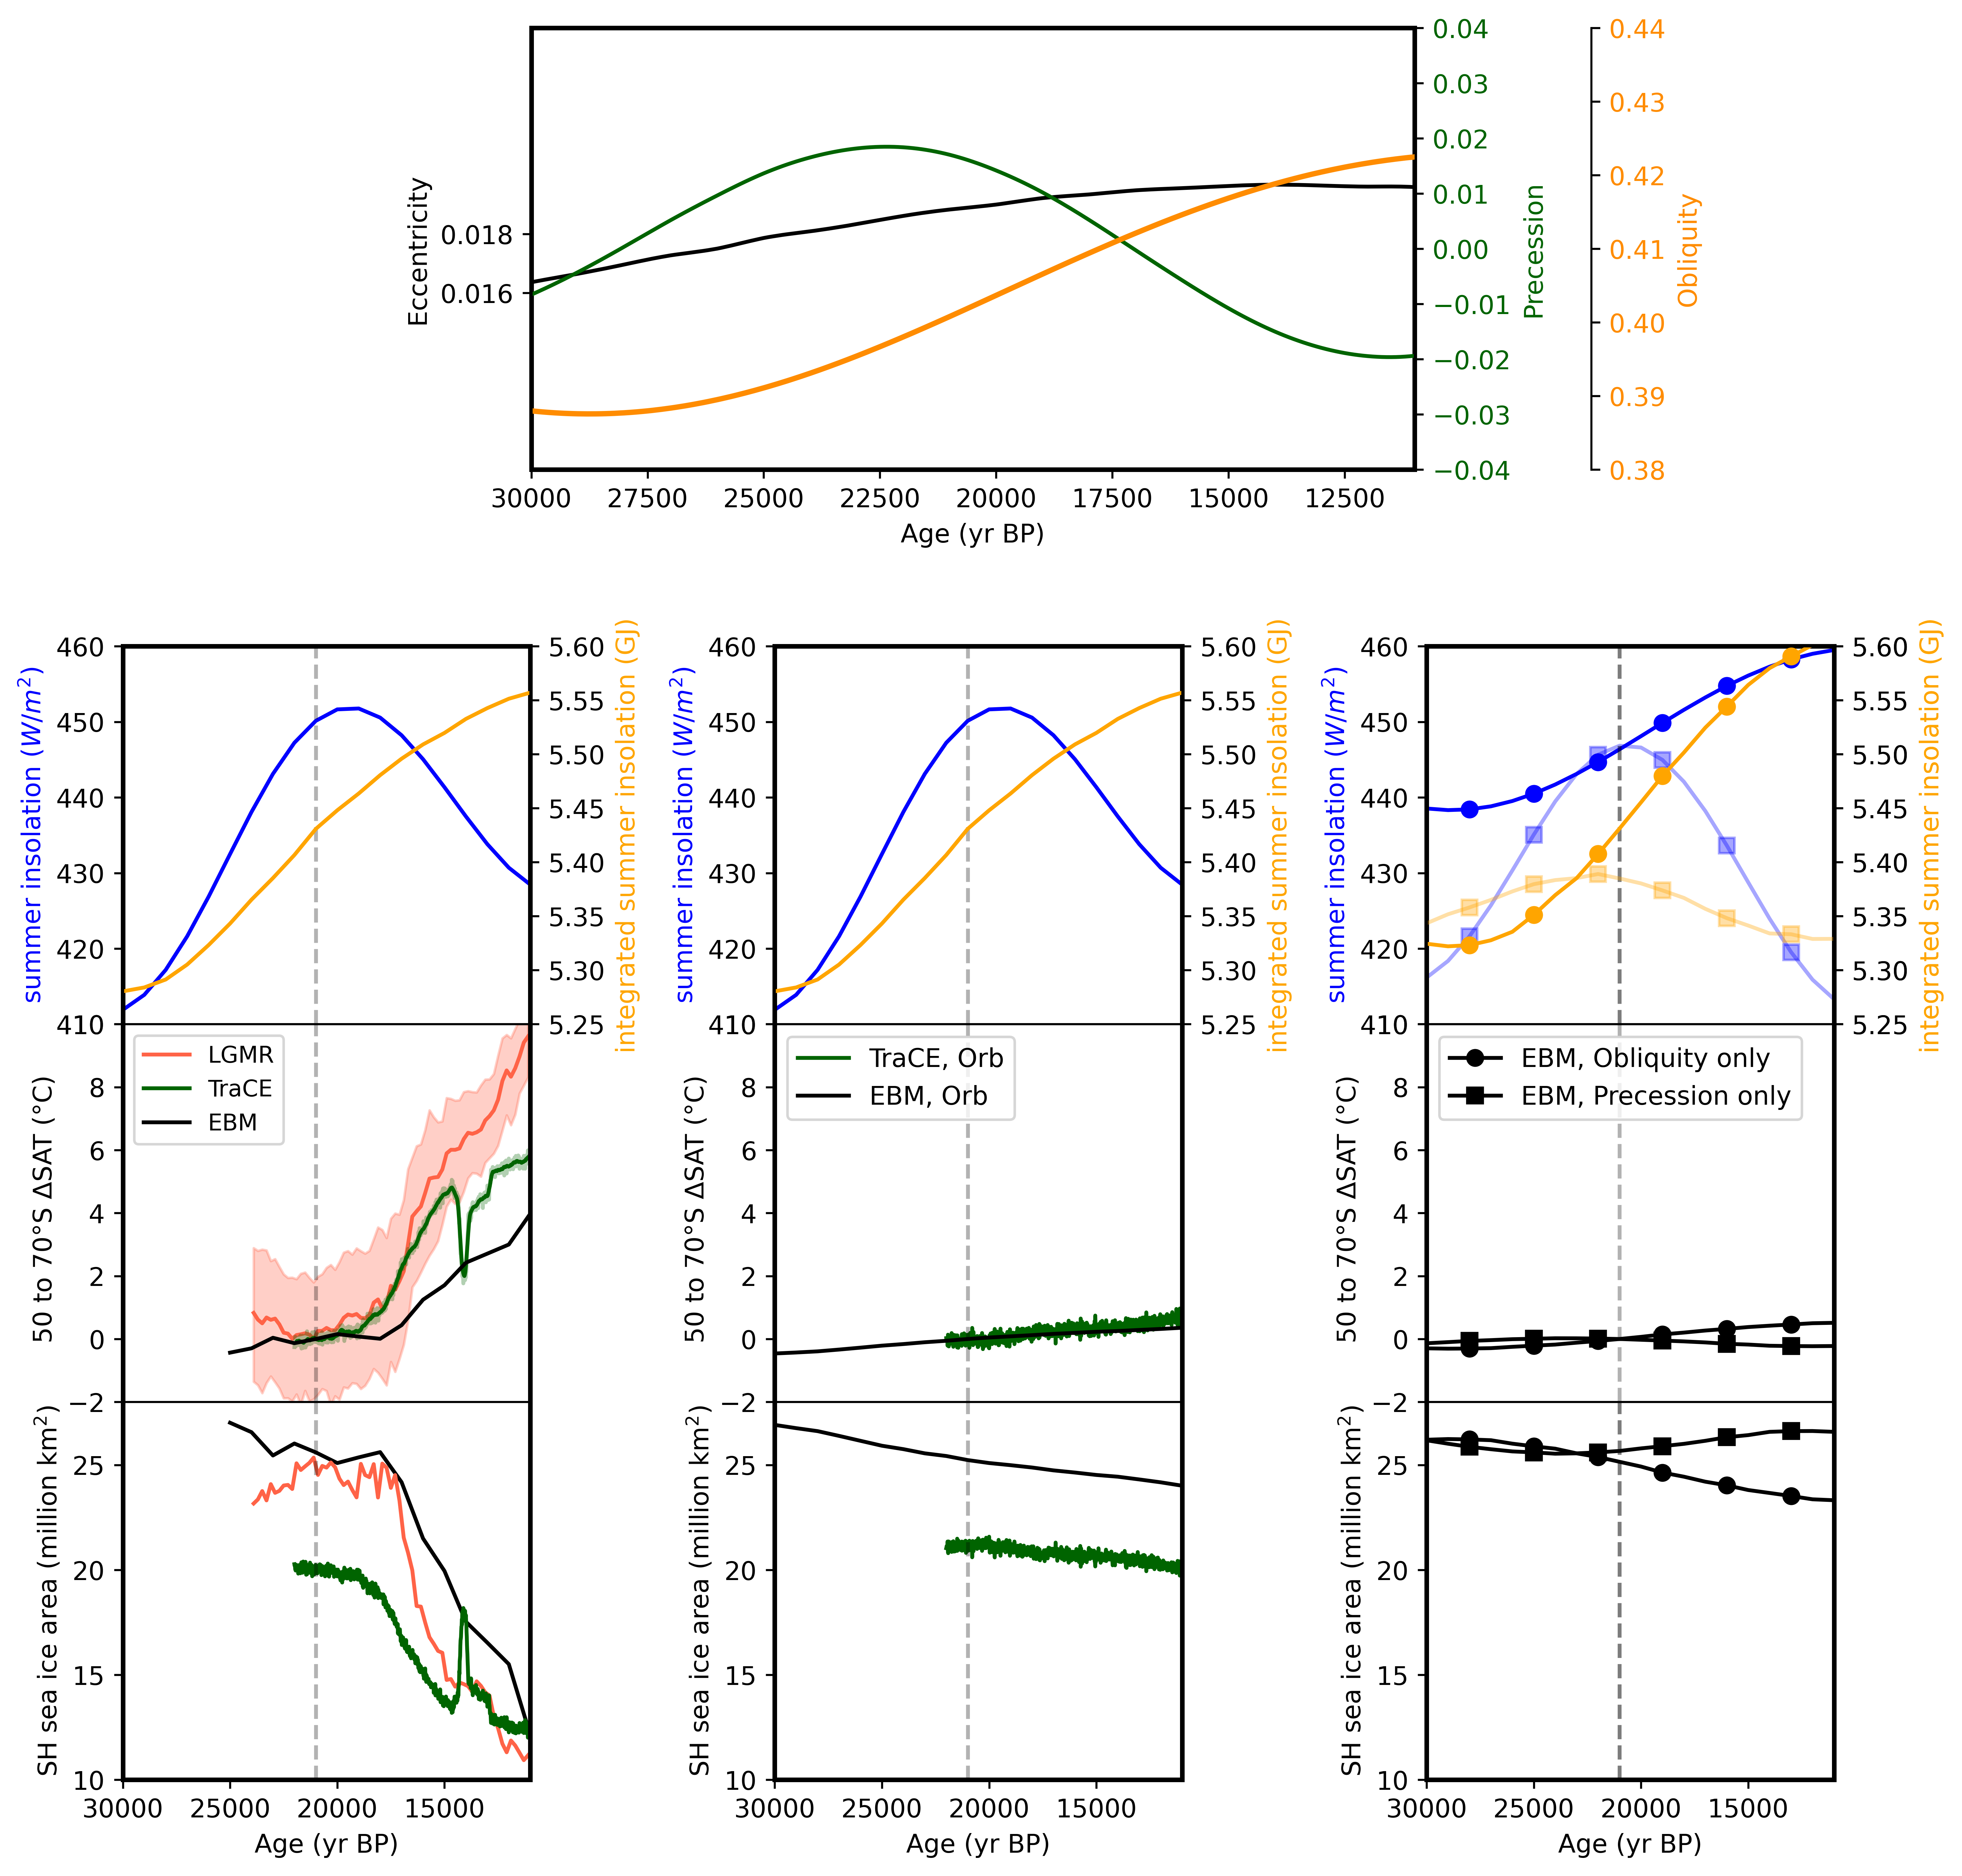

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from scipy.stats import zscore



# Periods for the vertical grey bars
HS1 = np.array([17480, 14692]) - 50  # convert to b1950
BA = np.array([14692, 12896]) - 50
YD = np.array([12896, 11703]) - 50

# Define the grey color with a transparency using RGBA tuple
grey_color = (0.8, 0.8, 0.8, 0.5)  # Grey color with 50% transparency.

# Function to add grey bars to the subplots
def add_grey_bars(ax):

    ax.axvspan(HS1[1], HS1[0], color='darkslategray', alpha=0.2, lw=0,zorder=-1)
    ax.axvspan(BA[1], BA[0], color='pink', alpha=0.2, lw=0,zorder=-1)
    ax.axvspan(YD[1], YD[0], color='navy', alpha=0.2, lw=0,zorder=-1)


sic_colors = {
    '0-60': 'brown',      
    '60-120': 'blue', 
    '120-180': 'blueviolet', 
    '180-240': 'green',  
    '240-300': 'olive',   
    '300-360': 'darkorange',    
}

# EBM_marker=['o','^','s','D','*']
EBM_label=['EBM','EBM, Orb','EBM, Obliquity only','EBM, Precession only']
EBM_marker=['none','none','o','s']
EBM_alpha=[1,1,1,0.35]
EBM_line=['-','-','-','-']
EBM_color=['k','k','k','k']

# emb_color=['blue','darkorange','darkgreen','black','magenta']
# emb_symbol=['o','^','s','D','*']



fig, axs = plt.subplots(3, 3, figsize=(12, 8), dpi=600, sharex=True)

ax_f = fig.add_axes([0.31, 1, 0.4, 0.3])

# Plot Eccentricity
ax_f.plot(df_ecc['age'], df_ecc['ecc'], color='k', label='Eccentricity', linestyle='-')
ax_f.set_ylabel('Eccentricity')
ax_f.set_xlabel('Age (yr BP)')
# set y axis limit
ax_f.set_ylim(0.01, 0.025)
# set y ticks
ax_f.set_yticks([0.016, 0.018])
ax_f.tick_params(axis='y')
ax_f.spines['bottom'].set_visible(False)

# ax_f.text(x=np.mean(HS1), y=0.99 * np.max(axs[0].get_ylim()), s='HS1', ha='center', va='top')
# ax_f.text(x=np.mean(BA), y=0.99 * np.max(axs[0].get_ylim()), s='BA', ha='center', va='top')
# ax_f.text(x=np.mean(YD), y=0.99 * np.max(axs[0].get_ylim()), s='YD', ha='center', va='top')
# invert the x axis
ax_f.invert_xaxis()
ax_f.set_xlim(30000,11000)

# Create first twin axis for Precession
ax0_1 = ax_f.twinx()
ax0_1.plot(df_pre['age'], df_pre['pre'], color='darkgreen', label='Precession', linestyle='-')
# set y axis limit
ax0_1.set_ylim(-0.04, 0.04)
ax0_1.set_ylabel('Precession', color='darkgreen')
ax0_1.tick_params(axis='y', labelcolor='darkgreen')
# show y axis and ticks on the right
ax0_1.yaxis.tick_right()
ax0_1.yaxis.set_label_position("right")
ax0_1.spines['bottom'].set_visible(False)

# Create second twin axis for Obliquity, positioned on the right
ax0_2 = ax_f.twinx()
# Offset the second twin axis to the right
ax0_2.spines["right"].set_position(("axes", 1.2))
ax0_2.plot(df_obl['age'], df_obl['obl'], color='darkorange', label='Obliquity', linewidth=2.1)
# set y axis limit
ax0_2.set_ylim(0.38, 0.44)
ax0_2.set_ylabel('Obliquity', color='darkorange')
ax0_2.tick_params(axis='y', labelcolor='darkorange')
# set the line width of the box
ax_f.spines['left'].set_linewidth(1.8)
ax_f.spines['right'].set_linewidth(1.8)
ax_f.spines['top'].set_linewidth(1.8)
ax0_2.spines['bottom'].set_linewidth(1.8)



for i in range(4):
    if i<3:
        ax = axs[0, i]
    else:
        ax = axs[0, i-1]
    
    if i==0 or i==1:
        ax.plot(ebm_list[1]['age'], ebm_list[1]['60S summer inso (21 Dec to 21 Feb)'], color='b',  label=EBM_label[i],linestyle=EBM_line[1])
        ax.set_ylim(410, 460)  # Corrected line
        ax.set_ylabel('summer insolation ($W/m^2$)', color='b')
        # ax.tick_params(axis='y', labelcolor='b')

        ax2 = ax.twinx()
        ax2.plot(ebm_list[1]['age'], ebm_list[1]['Inter_summer_inso'],color='orange', label=EBM_label[i],linestyle=EBM_line[1])
        ax2.set_ylim(5.25, 5.6)  # Corrected line
        ax2.set_ylabel('integrated summer insolation (GJ)', color='orange')
        # ax2.tick_params(axis='y', labelcolor='orange')
        # plot a vertical line at 21 ka
        ax.axvline(x=21000, color='k', linestyle='--',alpha=0.3)
    else:
        ax.plot(ebm_list[i]['age'], ebm_list[i]['60S summer inso (21 Dec to 21 Feb)'], color='b',  label=EBM_label[i],linestyle=EBM_line[i],marker=EBM_marker[i],markevery=3,alpha=EBM_alpha[i])
        ax.set_ylim(410, 460)  # Corrected line
        ax.set_ylabel('summer insolation ($W/m^2$)', color='b')
        # ax.tick_params(axis='y', labelcolor='b')

        ax2 = ax.twinx()
        ax2.plot(ebm_list[i]['age'], ebm_list[i]['Inter_summer_inso'], color='orange', label=EBM_label[i],linestyle=EBM_line[i],marker=EBM_marker[i],markevery=3,alpha=EBM_alpha[i])
        ax2.set_ylim(5.25, 5.6)  # Corrected line
        ax2.set_ylabel('integrated summer insolation (GJ)', color='orange')
        # ax2.tick_params(axis='y', labelcolor='orange')
        # plot a vertical line at 21 ka
        ax.axvline(x=21000, color='k', linestyle='--',alpha=0.3)



    
x1, x2, y1, y2 = 22000, 19000, -0.2, 0.8

for i in range(4):
    if i < 3:
        ax = axs[1, i]


        if i==0:
            weighted_avg_sat_mean_21=weighted_avg_sat_mean.sel(age=21000, method='nearest')
            ax.fill_between(ds_sat_EOFs_MC['age'], np.percentile(weighted_avg_sat_ens, 5, axis=0)-weighted_avg_sat_mean_21.values, np.percentile(weighted_avg_sat_ens, 95, axis=0)-weighted_avg_sat_mean_21.values, color='tomato', alpha=0.3)
            ax.plot(ds_sat_EOFs_MC['age'], weighted_avg_sat_mean-weighted_avg_sat_mean_21.values, color='tomato', label='LGMR')
            sat_series_allforcing_21=sat_series_allforcing[np.argmin(np.abs(trace_age-21000))]
            ax.plot(trace_age, sat_series_allforcing-sat_series_allforcing_21, color='darkgreen',alpha=0.3)
            ax.plot(trace_age, smoothed_sat_allforcing-sat_series_allforcing_21, color='darkgreen',label='TraCE')

        if i==1:
            sat_series_orb_21=sat_series_orb[np.argmin(np.abs(trace_age-21000))]
            ax.plot(trace_age, sat_series_orb-sat_series_orb_21,color='darkgreen',alpha=1,label='TraCE, Orb')


        # plot a vertical line at 21 ka
        ax.axvline(x=21000, color='k', linestyle='--',alpha=0.3)

        ebm_sat_21=ebm_list[i]['SAT (50 to 70S)'][ebm_list[i]['age']==21000].values
        ax.plot(ebm_list[i]['age'], ebm_list[i]['SAT (50 to 70S)'].values-ebm_sat_21,label=EBM_label[i],color=EBM_color[i],linestyle=EBM_line[i],marker=EBM_marker[i],markevery=3)
        if i==0:
            ax.legend(loc='upper left',fontsize=9)
        else:
            ax.legend(loc='upper left')
        ax.set_ylim(-2, 10)
        ax.set_ylabel(' 50 to 70°S ΔSAT (°C)')

    if i == 3:
        ax = axs[1, i-1]
        ebm_sat_21=ebm_list[i]['SAT (50 to 70S)'][ebm_list[i]['age']==21000].values
        ax.plot(ebm_list[i]['age'], ebm_list[i]['SAT (50 to 70S)'].values-ebm_sat_21,label=EBM_label[i],color=EBM_color[i],linestyle=EBM_line[i],marker=EBM_marker[i],markevery=3)
        ax.legend(loc='upper left')

    
# Plot the third row, the sea ice data
for i in range(4):
    if i < 3:
        ax = axs[2, i]

        # ebm_iceA_21=ebm_list[i]['iceA (SH)'][ebm_list[i]['age']==21000].values  
        ax.plot(ebm_list[i]['age'], ebm_list[i]['iceA (SH)'].values,color='k',label=EBM_label[i],linestyle=EBM_line[i],marker=EBM_marker[i],markevery=3) #  % Minors the area of Antrctic Ref: British Antarctic Surve; https://www.bas.ac.uk/about/antarctica/geography/ice/
        # set y axis limit
        ax.set_ylim(10, 28)
        ax.set_ylabel('SH sea ice area (million km$^2$)')
        # if i==0:
        #     ax.legend(loc='lower left',fontsize=9)

        if i==0:
            ax.plot(LGMR_sic_area[:,0], LGMR_sic_area[:,1], color='tomato', label='LGMR, SH')
            ax.plot(asice_trace_allforcing[:,0], asice_trace_allforcing[:,1], color='darkgreen', label='TraCE, all forcing')
            # ax_nores = ax.twinx()


            # def min_max_scaling(array):
            #     min_val = np.min(array)
            #     max_val = np.max(array)
            #     scaled_array = (array - min_val) / (max_val - min_val)
            #     return scaled_array

            # # get the df_proxy_seaice_pc data younger than 30 ka
            # df_proxy_seaice_pc_younger=df_proxy_seaice_pc[df_proxy_seaice_pc['Age (ka)']<30]

            # ax_nores.plot(df_proxy_seaice_pc_younger['Age (ka)']*1000, min_max_scaling(df_proxy_seaice_pc_younger['PC 1'].values), color='magenta',markersize=10, linewidth=2.5,linestyle='--',label='Proxy PC1')
            # # ax_nores.plot(0,0,color='darkorange',linestyle='-',marker='^',label='EBM, GHG+orbital')

            # ax_nores.set_ylabel('Normalized SIC', color='magenta')
            # ax_nores.legend(loc='lower left')

    if i==1:
        ax.plot(asice_trace_orb[:,0], asice_trace_orb[:,1], color='darkgreen', label='TraCE, orbital')
        # ax.legend(loc='lower left')
    # plot a vertical line at 21 ka
    ax.axvline(x=21000, color='k', linestyle='--',alpha=0.3)

    if i == 3:
        ax = axs[2, i-1]
        ax.plot(ebm_list[i]['age'], ebm_list[i]['iceA (SH)'].values,color='k',label=EBM_label[i],linestyle=EBM_line[i],marker=EBM_marker[i],markevery=3)
        # ax.legend(loc='lower left')


    
# invert x axis
axs[0,0].invert_xaxis()
# set xlim
axs[0,0].set_xlim(30000,11000)
# set x label
for i in range(3):
    axs[2,i].set_xlabel('Age (yr BP)')

for i in range(3):
    # set the line width of the box
    axs[0,i].spines['top'].set_linewidth(1.8)
    axs[0,i].spines['right'].set_linewidth(1.8)
    axs[0,i].spines['left'].set_linewidth(1.8)

    axs[1,i].spines['right'].set_linewidth(1.8)
    axs[1,i].spines['left'].set_linewidth(1.8)

    axs[2,i].spines['right'].set_linewidth(1.8)
    axs[2,i].spines['left'].set_linewidth(1.8)
    axs[2,i].spines['bottom'].set_linewidth(1.8)


fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.6)



# Show plot
plt.show()